In [22]:
import numpy as np
import random

Importing code file that includes the Popout class

In [23]:
from FinalConnect4 import *

In [24]:
class ColumnFullException(Exception):
    """An exception that will be thrown if a column of the board is full"""

    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)
    
class Learningagent:
    def __init__(self, player = 1, alpha=0.5, epsilon=0.1, discount=0.95):
        self.game = Game()
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
        self.q_values = {}
        self.player = 1

    
    def get_state(self):
        """
        Return the 2d list numerical representation of the board
        """
        result = tuple(tuple(x) for x in self.game.mat)
        return result
    
    def get_prev_state(self):
        """
        Return the previous state of the board
        """
        self.prev_state = None
        result = tuple(tuple(x) for x in self.prev_state)

        return result
    
    def get_actions(self,state):
        #gets all the possible actions that can be taken
        actions = []
        for i in range(self.game.cols):
            for j in range(2):
                if j == 0:
                    pop = True
                else:
                    pop = False
                if check_move(self.game,i,pop):
                    actions.append((i+1,pop))
        return actions


    def get_q_value(self, state, action):
        #Getting the q-value, setting initial to 1, so as to have optimisitic exploration
        if state not in self.q_values:
            self.q_values[state] = {}
        if action not in self.q_values[state]:
            self.q_values[state][action] = 1
        return self.q_values[state][action]

    def get_max_q_value(self, state):
        #function to get max q value
        max_q = -float("inf")
        for action in self.get_actions(state):
            q = self.get_q_value(state, action)
            if q > max_q:
                max_q = q
        return max_q    
    
    def get_rewards(self,game):
        #Getting the rewards for the games, 1 for a win, -1 for a loss, 0.5 for a tie
        reward = 0
        win_value = check_victory(game)
        if win_value == 3:
            reward = 0.5
        elif win_value == 1:
            reward = 1
        elif win_value == 2:
            reward = -1
        return reward
    
        
    def choose_action(self, state):
        """
        Return an action based on the best move recommendation by the current
        Q-Table with a epsilon chance of trying out a new move
        """
        current_state = state
        actions = self.get_actions(state)
        if random.random() < self.epsilon:  # explore!
            chosen_action = random.choice(actions)
            return chosen_action

        qs = [self.get_q_value(current_state, a) for a in actions]
        maxQ = max(qs)

        if qs.count(maxQ) > 1:
            # more than 1 best option; choose among them randomly
            best_options = [i for i in range(len(actions)) if qs[i] == maxQ]
            i = random.choice(best_options)
        else:
            i = qs.index(maxQ)
        return actions[i]

    #Using the Bellman Equation to    
    def update(self,state, action, next_state,reward):
        q = self.get_q_value(state, action)
        max_q = self.get_max_q_value(next_state)
        self.q_values[state][action] = q + self.alpha * (reward + self.discount*max_q - q)




#### In the SARSA Learning, contrary to QLearning which takes the the max of the q-value to update it using the Bellman Equation, SARSA just takes the next q-value of the next state and action. The actions are taken to be random.

In [25]:
sarsa_agent = Learningagent() #defining agent
winsarsa = {'Player_1':0,'Player_2':0,'Ties':0}
sarsamoves = []
for i in range(5000):
    sarsa_agent.game = Game()
    sarsa_agent.game.cols = 7
    sarsa_agent.game.rows = 6
    board_game = np.zeros((sarsa_agent.game.rows, sarsa_agent.game.cols))
    sarsa_agent.game.mat = board_game
    sarsa_agent.game.wins = 4
    moves = 0
    while not sarsa_agent.game.game_over:

        state1 = sarsa_agent.get_state()
        actions1 = sarsa_agent.get_actions(state1)
        action1 = random.choice(actions1)
        if action1[1] == False:
            apply_move(sarsa_agent.game, action1[0]-1, False)
            moves += 1
            sarsa_agent.game.turn = (sarsa_agent.game.turn + 1) % 2
            #display_board(sarsa_agent.game)
            #Use above to code see them play in live time
            
        else:
            apply_move(sarsa_agent.game, action1[0]-1, True)
            moves += 1
            sarsa_agent.game.turn = (sarsa_agent.game.turn + 1) % 2
            #display_board(sarsa_agent.game)
            #Use above to code see them play in live time
            
        #Updating q-value using Bellman equation for SARSA         
        state2 = sarsa_agent.get_state()
        actions2 = sarsa_agent.get_actions(state2)
        action2 = random.choice(actions2)
        reward = sarsa_agent.get_rewards(sarsa_agent.game)
        Qnext = sarsa_agent.get_q_value(state2, action2)
        q = sarsa_agent.get_q_value(state1,action1)
        sarsa_agent.q_values[state1][action1] = q + sarsa_agent.alpha * (reward + sarsa_agent.discount*Qnext - q)
        
        #Checking if the game is over 
        if check_victory(sarsa_agent.game) == 1 or check_victory(sarsa_agent.game) == 2 or check_victory(sarsa_agent.game) == 3:
            
            if check_victory(sarsa_agent.game) == 1:
                winsarsa['Player_1'] += 1
                #Player 1 won!    
            elif check_victory(sarsa_agent.game) == 2:
                winsarsa['Player_2'] += 1
                #Player 2 won!
            elif check_victory(sarsa_agent.game) == 3:
                winsarsa['Ties'] += 1
                #It's a tie.
            sarsamoves.append((moves))
            sarsa_agent.game.game_over = True


In [26]:
winsarsa['Player_1']/(winsarsa['Player_2'] + winsarsa['Player_1'])

0.5196

In [27]:
np.mean(sarsamoves)

28.2688

#### QLearning agent 

In [28]:
#Code takes long to run
qlagent = Learningagent()
qlmoves = []
qlwins = {"Player_1":0,'Player_2':0,'Ties':0}
for i in range(5000):
    #taking 5000 iterations
    qlagent.game = Game()
    qlagent.game.cols = 7
    qlagent.game.rows = 6
    board_game = np.zeros((qlagent.game.rows, qlagent.game.cols))
    qlagent.game.mat = board_game
    qlagent.game.wins = 4
    moves = 0
    #starting game
    while not qlagent.game.game_over:
        state1 = qlagent.get_state()
        actions1 = qlagent.get_actions(state1)
        action1 = qlagent.choose_action(state1)
        if action1[1] == False:
            apply_move(qlagent.game, action1[0]-1, False)
            moves +=1
            qlagent.game.turn = (qlagent.game.turn + 1) % 2
            #display_board(qlagent.game)
            #Use above to code see them play in live time
        else:
            apply_move(qlagent.game, action1[0]-1, True)
            moves += 1
            qlagent.game.turn = (qlagent.game.turn + 1) % 2
            #display_board(qlagent.game)
            #Use above to code see them play in live time
        
        #updating the Q-value using Bellman equation
        next_state = qlagent.get_state()
        reward = qlagent.get_rewards(qlagent.game)
        qlagent.update( state1, action1, next_state,reward)
        
        if check_victory(qlagent.game) == 1 or check_victory(qlagent.game) == 2 or check_victory(qlagent.game) == 3:
            if check_victory(qlagent.game) == 1 :
                qlwins['Player_1']+=1    
            elif check_victory(qlagent.game) == 2 :
                qlwins['Player_2']+=1
            elif check_victory(qlagent.game) == 3 :
                qlwins['Ties']+=1
            qlmoves.append((moves))
            qlagent.game.game_over = True

In [29]:
qlwins

{'Player_1': 3959, 'Player_2': 1041, 'Ties': 0}

In [30]:
qlwins['Player_1']/(qlwins['Player_2'] + qlwins['Player_1'])


0.7918

Qlearning has a much higher first player win percentage than SARSA.

In [31]:
np.mean(qlmoves)

17.1242

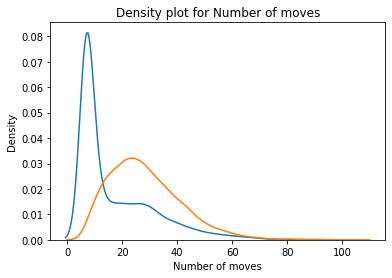

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(qlmoves)
sns.kdeplot(sarsamoves)
plt.xlabel("Number of moves")
plt.title("Density plot for Number of moves")
plt.savefig('Movesvs.png')

### QLearning vs SARSA

When Qlearning agent is the first player-

In [33]:
listmoves = []
wins = {"Player_1": 0, 'Player_2': 0, 'Ties': 0}
for i in range(5000):
    game = Game()
    game.cols = 7
    game.rows = 6
    board_game = np.zeros((game.rows, game.cols))
    game.mat = board_game
    game.wins = 4
    moves = 0
    sarsa_agent.game = game
    qlagent.game = game
    while not qlagent.game.game_over:
        if qlagent.game.turn == 0:
            state1 = qlagent.get_state()
            actions1 = qlagent.get_actions(state1)
            action1 = qlagent.choose_action(state1)
            
            if action1[1] == False:
                apply_move(qlagent.game, action1[0]-1, False)
                moves += 1
                qlagent.game.turn = (qlagent.game.turn + 1) % 2
            else:
                apply_move(qlagent.game, action1[0]-1, True)
                moves += 1
                qlagent.game.turn = (qlagent.game.turn + 1) % 2       
            next_state = qlagent.get_state()
            reward = qlagent.get_rewards(qlagent.game)
            qlagent.update(state1, action1, next_state, reward)
        else:
            sarsa_agent.game.mat = qlagent.game.mat
            state1 = sarsa_agent.get_state()
            actions1 = sarsa_agent.get_actions(state1)
            action1 = random.choice(actions1)
            if action1[1] == False:
                apply_move(sarsa_agent.game, action1[0]-1, False)
                moves += 1
                sarsa_agent.game.turn = (sarsa_agent.game.turn + 1) % 2
            else:
                apply_move(sarsa_agent.game, action1[0]-1, True)
                moves += 1
                sarsa_agent.game.turn = (sarsa_agent.game.turn + 1) % 2

            state2 = sarsa_agent.get_state()
            actions2 = sarsa_agent.get_actions(state2)
            action2 = random.choice(actions2)
            reward = sarsa_agent.get_rewards(sarsa_agent.game)
            Qnext = sarsa_agent.get_q_value(state2, action2)
            q = sarsa_agent.get_q_value(state1, action1)
            sarsa_agent.q_values[state1][action1] = q + sarsa_agent.alpha * (reward + sarsa_agent.discount*Qnext - q)
            qlagent.game.mat = sarsa_agent.game.mat
        
        if check_victory(qlagent.game) == 1 or check_victory(qlagent.game) == 2 or check_victory(qlagent.game) == 3:
            if check_victory(qlagent.game) == 1:
                wins['Player_1'] += 1
            elif check_victory(qlagent.game) == 2:
                wins['Player_2'] += 1
            elif check_victory(qlagent.game) == 3:
                wins['Ties'] += 1
            listmoves.append((moves))
            qlagent.game.game_over = True


In [34]:
wins['Player_1']/(wins['Player_2'] +wins['Player_1'])  #Win percentage of Qlearning vs SARSA when Qlearning goes first

0.5912

When SARSA agent is the first player-

In [35]:
listmoves2 = []
wins2 = {"Player_1": 0, 'Player_2': 0, 'Ties': 0}
for i in range(5000):
    game = Game()
    game.cols = 7
    game.rows = 6
    board_game = np.zeros((game.rows, game.cols))
    game.mat = board_game
    game.wins = 4
    moves = 0
    sarsa_agent.game = game
    qlagent.game = game
    while not qlagent.game.game_over:
        if qlagent.game.turn == 1:
            state1 = qlagent.get_state()
            actions1 = qlagent.get_actions(state1)
            action1 = qlagent.choose_action(state1)

            if action1[1] == False:
                apply_move(qlagent.game, action1[0]-1, False)
                moves += 1
                qlagent.game.turn = (qlagent.game.turn + 1) % 2
            else:
                apply_move(qlagent.game, action1[0]-1, True)
                moves += 1
                qlagent.game.turn = (qlagent.game.turn + 1) % 2
            next_state = qlagent.get_state()
            reward = qlagent.get_rewards(qlagent.game)
            qlagent.update(state1, action1, next_state, reward)
        else:
            sarsa_agent.game.mat = qlagent.game.mat
            state1 = sarsa_agent.get_state()
            actions1 = sarsa_agent.get_actions(state1)
            action1 = random.choice(actions1)
            if action1[1] == False:
                apply_move(sarsa_agent.game, action1[0]-1, False)
                moves += 1
                sarsa_agent.game.turn = (sarsa_agent.game.turn + 1) % 2
            else:
                apply_move(sarsa_agent.game, action1[0]-1, True)
                moves += 1
                sarsa_agent.game.turn = (sarsa_agent.game.turn + 1) % 2

            state2 = sarsa_agent.get_state()
            actions2 = sarsa_agent.get_actions(state2)
            action2 = random.choice(actions2)
            reward = sarsa_agent.get_rewards(sarsa_agent.game)
            Qnext = sarsa_agent.get_q_value(state2, action2)
            q = sarsa_agent.get_q_value(state1, action1)
            sarsa_agent.q_values[state1][action1] = q + \
                sarsa_agent.alpha * (reward + sarsa_agent.discount*Qnext - q)
            qlagent.game.mat = sarsa_agent.game.mat

        if check_victory(qlagent.game) == 1 or check_victory(qlagent.game) == 2 or check_victory(qlagent.game) == 3:
            if check_victory(qlagent.game) == 1:
                wins2['Player_1'] += 1
            elif check_victory(qlagent.game) == 2:
                wins2['Player_2'] += 1
            elif check_victory(qlagent.game) == 3:
                wins2['Ties'] += 1
            listmoves2.append((moves))
            qlagent.game.game_over = True


In [36]:
wins2['Player_1']/(wins['Player_2']+wins2['Player_1']) #win percentage of SARSA vs Qlearning when SARSA goes first

0.5802874743326488

Win percentages of both the agents are comparable, and a bit random. But overall, first turn does matter more, even though popout is much less affected by the first turn compared to the traditional Connect4.